## Path Parameters

In [1]:
import os

ROOT_DIR= os.path.abspath("../Mask_RCNN/")
MODEL_DIR = os.path.abspath("../models/")
DATASET_DIR= os.path.abspath("../MangaBubbles/")
DEFAULT_LOGS_DIR = MODEL_DIR

print("Root:", ROOT_DIR)
print("Models:", MODEL_DIR)
print("Dataset:", DATASET_DIR)

Root: C:\Programming\NotAnotherBubbleCleaner\Mask_RCNN
Models: C:\Programming\NotAnotherBubbleCleaner\models
Dataset: C:\Programming\NotAnotherBubbleCleaner\MangaBubbles


## Imports

In [2]:
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import datetime

import skimage.draw
import cv2
import glob

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn.model import log
from mrcnn import model as modellib, utils

%matplotlib inline 

# disable TF warnings
import tensorflow
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


## Dataset

In [37]:
"""
Dataset directory should be structured as:

(root)
    train/
       images/
           image_1.png
       masks/
           image_1/
               mask_1.png
               mask_2.png
               mask_3.png
    
    val/
        images/
        masks/
        
where each mask_#.png is the binary mask for a single bubble.
"""

class BubblesDataset(utils.Dataset):
    def load_shapes(self, subset):
        self.subset= subset
        self.add_class("bubbles", 1, "bubble")
            
        filelist= os.listdir(os.path.join(DATASET_DIR, subset, 'images'))
        for file in filelist:
            if ".png" not in file and ".jpg" not in file and ".jpeg" not in file:
                continue
            image_path = os.path.join(DATASET_DIR, subset, 'images', file)
            try:
                image = skimage.io.imread(image_path)
            except Exception as e:
                print(image_path)
                print(e)
            height, width = image.shape[:2]
            
            #print(f'file {file}')
            self.add_image(
                "bubbles",
                image_id=file,
                name=file,
                path= os.path.join(DATASET_DIR, subset, 'images', file),
                width=width, height=height)

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        
        ext= os.path.splitext(image_info["name"])[1]
        fdir= DATASET_DIR + "/" + self.subset + "/masks/" + image_info["name"][:-len(ext)]
        if not (os.path.exists(fdir)):
            print(fdir)
            assert(os.path.exists(fdir))
        
        
        ids=[]
        masks= []
        for file in glob.glob(fdir + "/*.png"):
            if len(masks)!=0:
                img = cv2.imread(file, 0).astype(np.bool)
                #print(file, masks.shape, img.shape)
                masks= np.dstack((masks, img))
                ids.append(1)
            else:
                masks= cv2.imread(file, 0).astype(np.bool)
                ids.append(1)
        
        if len(masks.shape) < 3:
            masks= np.expand_dims(masks, axis=2)
        return masks, np.ones(len(ids), dtype=np.int32)
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "bubbles":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
            
    def load_image(self, image_id):
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 1:
            image = skimage.color.rgb2gray(image)
        if np.max(image) <= 1:
            image= image*255
        image = image[..., np.newaxis]
        #print(image.shape, " ", self.image_info[image_id]['path'])
        return image

## Training Parameters

In [4]:
class BubblesConfig(Config):    
    BACKBONE= 'resnet50'

    IMAGE_RESIZE_MODE='crop'
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    STEPS_PER_EPOCH= 10
    EPOCHS= 5
    
    IMAGE_CHANNEL_COUNT= 1
    MEAN_PIXEL= np.array([123.7])
    
    TRAIN_ROIS_PER_IMAGE = 30
    
    
    NAME = "bubbles"
    NUM_CLASSES = 1 + 1  # background + bubble
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
config = BubblesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [64 64  1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 1

In [5]:
dataset_train = BubblesDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()
print(len(dataset_train.image_ids), 'training images')

dataset_val = BubblesDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()
print(len(dataset_val.image_ids), 'validation images')

632 training images
90 validation images


In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [7]:
# model.load_weights(model.find_last(), by_name=True)

## Training

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1,
            layers='all')

## Detection

In [9]:
class InferenceConfig(BubblesConfig):
    IMAGE_RESIZE_MODE='square'
    IMAGE_MIN_DIM=1728
    IMAGE_MAX_DIM=1728
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  1728
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1728
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1728 1728    1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE      

In [18]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path= os.path.abspath("../models/model.h5")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Programming\NotAnotherBubbleCleaner\models\model.h5


(1728, 1728, 3)
original_image           shape: (1728, 1728, 3)       min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max: 1728.00000  float64
gt_class_id              shape: (7,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (7, 4)                min:   51.00000  max: 1534.00000  int32
gt_mask                  shape: (1728, 1728, 7)       min:    0.00000  max:    1.00000  bool


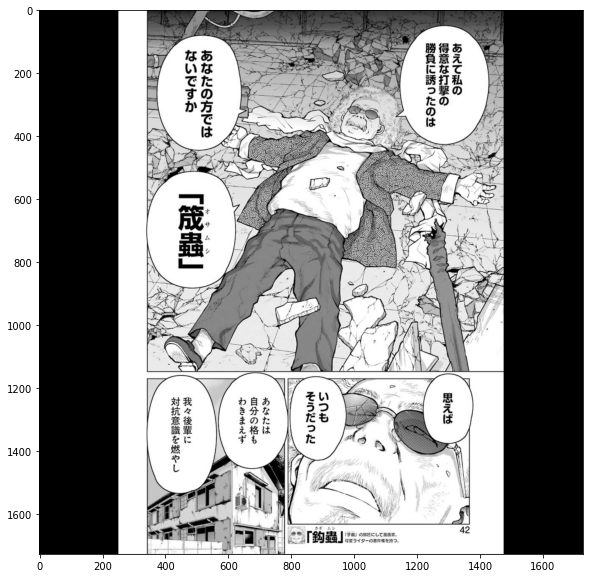

In [32]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

if np.max(original_image) <= 1: original_image= original_image*255
disp_image= np.concatenate((original_image, original_image, original_image),axis=2)
print(disp_image.shape)

log("original_image", disp_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

def get_ax(rows=1, cols=1, size=10):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

get_ax().imshow(disp_image.astype(np.uint8))

Processing 1 images
image                    shape: (1728, 1728, 1)       min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 1728, 1728, 1)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1728.00000  int32
anchors                  shape: (1, 745767, 4)        min:   -0.20963  max:    1.17258  float32
(1728, 1728, 3)


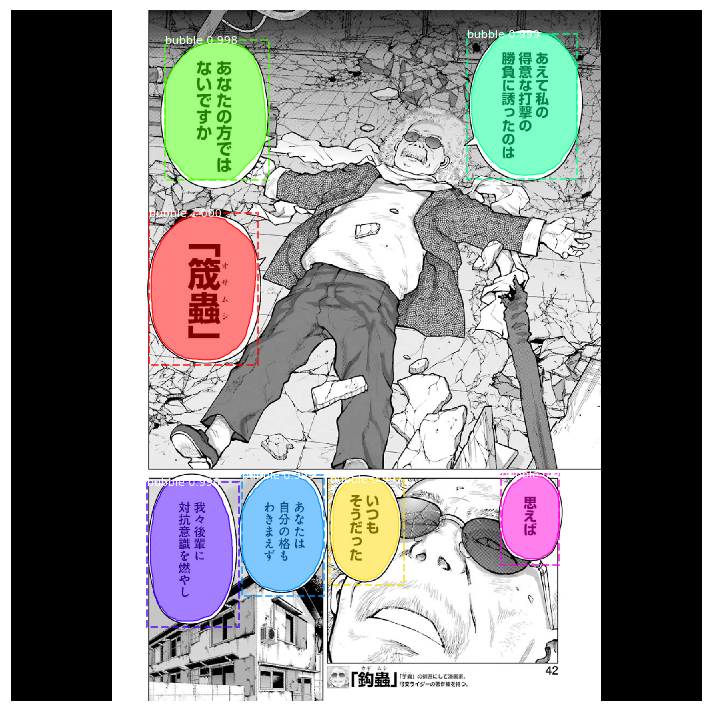

In [33]:
results = model.detect([original_image], verbose=1)

r = results[0]

inds= []
for i in reversed(range(len(r['scores']))):
    if r['scores'][i] > .98:
        break
    else:
        inds.append(i)
r['masks']= np.delete(r['masks'], inds, 2)
r['scores']= np.delete(r['scores'], inds, 0)
r['class_ids']= np.delete(r['class_ids'], inds, 0)
r['rois']= np.delete(r['rois'], inds, 0)
    
    
im= visualize.display_instances(disp_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


skimage.io.imshow(im)
print(im.shape)

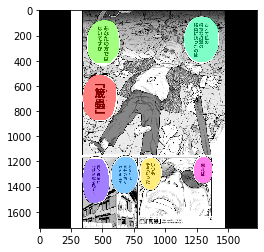

In [34]:
plt.imshow(im, interpolation='nearest')
plt.show()

In [35]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

KeyboardInterrupt: 